In [ ]:
# Create connection to Kaggle and Snowflake

In [35]:
import pandas as pd 
import glob 
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas
import json

# Location of your project
conn_location = '/Users/you_file_folder_location/'

connect = json.loads(open(str(conn_location+'conection_file_name.json')).read())

# Kaggle connection setup
os.environ["KAGGLE_CONFIG_DIR"] = conn_location
os.environ['KAGGLE_USERNAME'] = connect['kaggle']['username']
os.environ['KAGGLE_KEY'] = connect['kaggle']['key']

# Connect with kaggle API
api = KaggleApi()
api.authenticate()


# Download the dataset using Kaggle API (kaggle dataset location)
dataset_path = 'dataset_owner/dataset_name'
# kaggle datasets download -d dataset_owner/dataset_name


# Using the KaggleApi class directly
api.dataset_download_files(dataset_path, path=conn_location, unzip=True)
 

# Setup snowflake connection...
username = connect['secrets']['username']
password = connect['secrets']['password']
account = connect['secrets']['account']
role = connect['secrets']['role']

conn = snowflake.connector.connect(
    user=username,
    password=password,
    account=account,
    role=role
)

# Set database and schema for snowflake
demo_db = connect['secrets']['database'].upper()
da_pre_schema = 'PRE_DAPY'

conn.cursor().execute(f"USE DATABASE {demo_db}")
conn.cursor().execute(f"CREATE SCHEMA IF NOT EXISTS {da_pre_schema}")
conn.cursor().execute(f"USE SCHEMA {da_pre_schema}")

# Process each CSV file
da_demo_files = glob.glob(os.path.join(conn_location, "*.csv"))

# Datatype validation
def map_dtype(pandas_dtype):
    dtype_str = str(pandas_dtype)
    if dtype_str == 'int64':
        return 'INT'
    elif dtype_str.startswith('float'):
        return 'FLOAT'
    elif dtype_str == 'bool':
        return 'BOOLEAN'
    elif dtype_str == 'datetime64[ns]':
        return 'DATETIME'
    elif dtype_str == 'object':
        # Default object type to VARCHAR
        return 'VARCHAR'
    else:
        # Catch-all for any unhandled data types
        return 'VARCHAR'

# Read and insert data to snoflake database
for file in da_demo_files:
    filename = os.path.splitext(os.path.basename(file))[0].upper()
    da_pre_table = f'PRE_DAPY_{filename}'

    dfDA = pd.read_csv(file,index_col = 0)
    dfDA.rename(columns=str.upper, inplace=True)
    
    print(dfDA)
    
    #In my dataset example I needed to drop first column
    if 'INDEX' in dfDA.columns:
        dfDA = dfDA.drop(columns=['INDEX'])

    # Reset index if it's a MultiIndex - needed in my example
    if isinstance(dfDA.index, pd.Index) and not isinstance(dfDA.index, pd.RangeIndex):
        dfDA.reset_index(inplace=True)
        dfDA.rename(columns={'index': 'COLUMN_ID'}, inplace=True)

    #Insert columns to dict
    col_dtypes = dfDA.dtypes.to_dict()

    # Building the CREATE TABLE SQL statement
    create_tbl_sql = f"CREATE TABLE IF NOT EXISTS {demo_db}.{da_pre_schema}.{da_pre_table} ("
    create_tbl_sql += ', '.join([f"{col} {map_dtype(str(col_dtypes[col]))}" for col in dfDA.columns])
    create_tbl_sql += ")"

    try:
        conn.cursor().execute(create_tbl_sql)
        # Specify the database and schema for the TRUNCATE TABLE command
        conn.cursor().execute(f'TRUNCATE TABLE IF EXISTS {demo_db}.{da_pre_schema}.{da_pre_table}')
        write_pandas(conn, df=dfDA, table_name=da_pre_table, database=demo_db, schema=da_pre_schema)
    except Exception as e:
        print(f"Error processing file {file}: {e}")

       INDEX                                              TITLE  \
0          0                                       Data Analyst   
1          1       Entry Level - Business Data Analyst (Remote)   
2          2                            Data Analyst/Researcher   
3          3  Data analyst/AI expert to help build a website...   
4          4                                       Data Analyst   
...      ...                                                ...   
39944    494                     Marketing Data & BI Analyst II   
39945    495                                  Lead-Data Analyst   
39946    496                                  Lead-Data Analyst   
39947    497                                  Lead-Data Analyst   
39948    498  Institutional Credit Management - Lending Data...   

                           COMPANY_NAME            LOCATION  \
0                          Cisco Meraki           Anywhere    
1                      Midwest Staffing           Anywhere    
2     

In [7]:
    dfDA.dtypes
    print(dfDA)
    print(dfDA.head())
    print(dfDA.dtypes)

       COLUMN_ID                                              TITLE  \
0              0                                       Data Analyst   
1              1       Entry Level - Business Data Analyst (Remote)   
2              2                            Data Analyst/Researcher   
3              3  Data analyst/AI expert to help build a website...   
4              4                                       Data Analyst   
...          ...                                                ...   
39356      39356                     Marketing Data & BI Analyst II   
39357      39357                                  Lead-Data Analyst   
39358      39358                                  Lead-Data Analyst   
39359      39359                                  Lead-Data Analyst   
39360      39360  Institutional Credit Management - Lending Data...   

                           COMPANY_NAME            LOCATION  \
0                          Cisco Meraki           Anywhere    
1                    

In [39]:
# SQL query to get data
query = f"SELECT * FROM {demo_db}.{da_pre_schema}.{da_pre_table}"  

# Execute the query
cur = conn.cursor()
cur.execute(query)

# Fetch the result set from the cursor and load into a DataFrame
df = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

# Close the cursor
cur.close()

True

In [37]:
print(df)

       COLUMN_ID                                              TITLE  \
0          32768                       Business Information Analyst   
1          32769                   Data Analytics ( Telecom Domain)   
2          32770                                      Data Engineer   
3          32771               Marketing Data & BI Analyst - Remote   
4          32772                     Business Data Analyst W-2 Only   
...          ...                                                ...   
39944      32763  Environment Management Lead  & Data Conversion...   
39945      32764                             Data Analyst - ONLY W2   
39946      32765                   Senior Supply Chain Data Analyst   
39947      32766                   Senior Supply Chain Data Analyst   
39948      32767                       Business Information Analyst   

                    COMPANY_NAME    LOCATION           VIA  \
0                 Insight Global    Anywhere  via LinkedIn   
1                      

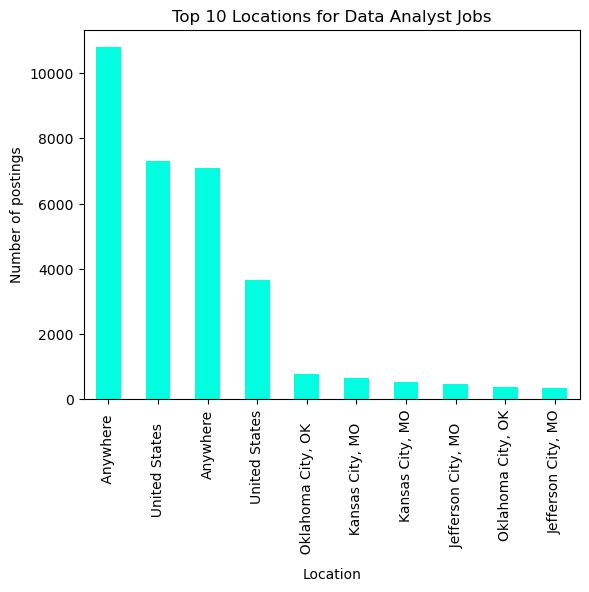

In [38]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

grey_colors = LinearSegmentedColormap.from_list('grey_grad', ['#00FFE0', '#a9a9a9', '#808080'])


location_counts = df['LOCATION'].value_counts()

location_counts.head(10).plot(kind='bar', colormap=grey_colors)
plt.title("Top 10 Locations for Data Analyst Jobs")
plt.xlabel("Location")
plt.ylabel("Number of postings")
plt.show()

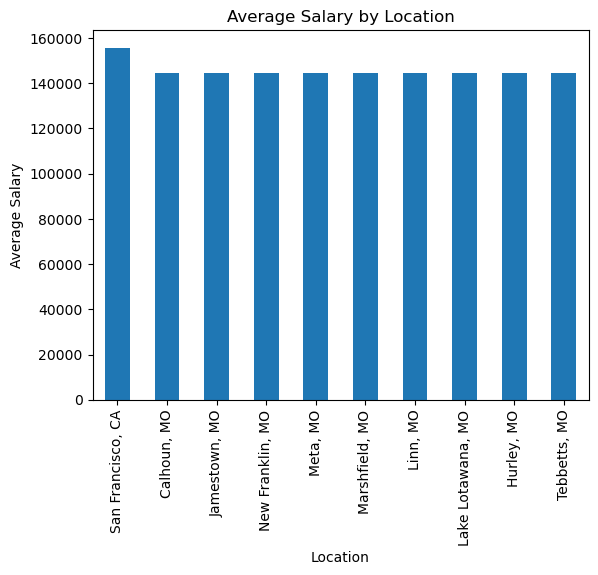

In [18]:
# Assuming SALARY_AVG column has average salary data

# Convert salary column to numeric
df['SALARY_AVG'] = pd.to_numeric(df['SALARY_AVG'], errors='coerce')

# Average salary by location
avg_salary_by_location = df.groupby('LOCATION')['SALARY_AVG'].mean()

# Plotting
avg_salary_by_location.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Average Salary by Location')
plt.xlabel('Location')
plt.ylabel('Average Salary')
plt.show()

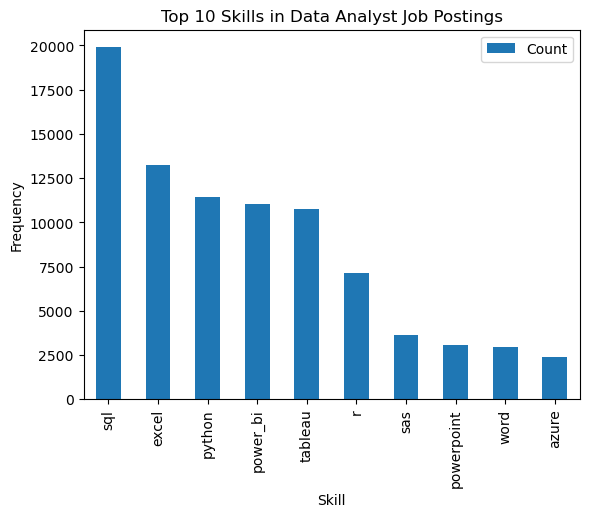

In [19]:
from collections import Counter
import ast

# Convert string representation of list to actual list
df['DESCRIPTION_TOKENS'] = df['DESCRIPTION_TOKENS'].apply(ast.literal_eval)

# Flatten the list of lists
all_skills = [skill for sublist in df['DESCRIPTION_TOKENS'] for skill in sublist]

# Count frequency of each skill
skill_counts = Counter(all_skills)

# Top 10 skills
top_skills = pd.DataFrame(skill_counts.most_common(10), columns=['Skill', 'Count'])

# Plot
top_skills.plot(x='Skill', y='Count', kind='bar')
plt.title('Top 10 Skills in Data Analyst Job Postings')
plt.xlabel('Skill')
plt.ylabel('Frequency')
plt.show()

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

# Combine all job descriptions into a single string
all_descriptions = " ".join(df['DESCRIPTION'].astype(str))

# Use CountVectorizer for keyword extraction
vectorizer = CountVectorizer(stop_words='english', max_features=10)
X = vectorizer.fit_transform([all_descriptions])

# Get feature names (top keywords)
keywords = vectorizer.get_feature_names_out()

print("Top 10 Keywords in Job Descriptions:", keywords)

Top 10 Keywords in Job Descriptions: ['ability' 'analysis' 'analytics' 'business' 'data' 'experience'
 'management' 'skills' 'team' 'work']


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Selecting relevant columns
# Assuming 'SALARY_AVG' is your target variable and it's already calculated
relevant_columns = ['TITLE', 'COMPANY_NAME', 'LOCATION', 'DESCRIPTION', 'SALARY_AVG']
df = df[relevant_columns]

# Drop rows where salary is NaN
df = df.dropna(subset=['SALARY_AVG'])

# Label Encoding for categorical variables
for column in ['TITLE', 'COMPANY_NAME', 'LOCATION', 'DESCRIPTION']:
    df[column] = LabelEncoder().fit_transform(df[column])
    
X = df.drop('SALARY_AVG', axis=1)
y = df['SALARY_AVG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 30914.45243167573
